## NEW URL 크롤링

In [35]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [36]:
url_list = make_urllist(2, 105, 20231128)
print('뉴스 기사의 개수: ',len(url_list))
url_list[:5]

뉴스 기사의 개수:  40


['https://n.news.naver.com/mnews/article/009/0005222155?sid=105',
 'https://n.news.naver.com/mnews/article/020/0003533945?sid=105',
 'https://n.news.naver.com/mnews/article/092/0002313077?sid=105',
 'https://n.news.naver.com/mnews/article/008/0004967473?sid=105',
 'https://n.news.naver.com/mnews/article/056/0011611479?sid=105']

## 뉴스 URL에서 뉴스 불러오기

In [37]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [4]:
from newspaper import Article
from tqdm import tqdm

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in tqdm(urllist):
    article = Article(url, language='ko')
    try:
        article.download()
        article.parse()
    except:
        print("연결에 실패했습니다.")
        continue
    text_list.append(article.title)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [5]:
data = make_data(url_list, 105)
#- 상위 10개만 출력해봅니다.
data[:10]

100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


,news,code
0,우리 할머니 인슐린 주사 그만 맞아도 될까…‘당뇨 완치’ 길 열리나,IT/과학
1,"강스템바이오텍, ‘퓨어스템 오에이 키트주’ 임상 순항… “기술수출에 최선”",IT/과학
2,"DN솔루션즈, 獨 테크니컬 센터 열어…""유럽 시장 잡는다""",IT/과학
3,대구경북과학기술원 신임 총장에 이건우 서울대 전 공대 학장,IT/과학
4,울산 남구 테크노산업로 일원 자율주행차 시범운행지구 지정,IT/과학
5,"유니스트, ‘세계에서 가장 영향력 있는 연구자’ 9명",IT/과학
6,"이용훈 총장, 과기부 장관 ‘물망’…유니스트는?",IT/과학
7,"쿠쿠전자, 대용량 '아이편한 가습기 7S' 출시",IT/과학
8,욕설 논란에 카르텔 폭로까지…스텝 꼬인 김범수 쇄신안,IT/과학
9,“이런 XXX같은” 욕설 회의... 카카오 임원 “문제점 지적하다 실수”,IT/과학


In [346]:
code_list = [101, 102, 103, 104, 105]

In [350]:

def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [ ]:
df = make_total_data(10, code_list, 20231128)

 40%|███▉      | 237/600 [03:37<05:51,  1.03it/s]

In [90]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  2232


In [40]:
startdate = 20231129
df2 = None
for i in range(5):
    date = startdate + i
    tmp = make_total_data(10, code_list, date)
    
    if i == 0:
        df2 = tmp
    else:
        df2.concat([df, tmp])

102번 코드에 대한 데이터를 만들었습니다.
연결에 실패했습니다.
103번 코드에 대한 데이터를 만들었습니다.
연결에 실패했습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [63]:
df = pd.concat([df, df2])
df

,news,code
0,돈가스 3kg으로 85명 원생 배식한 어린이집 원장 재판行,사회
1,[뉴스특보 LIVE] 2030 엑스포 개최지 발표 “부산의 도전”,사회
2,동명이인 환자 명의로 '의료용 마약류' 처방받은 의사,사회
3,"""만원의 가치, 만원의 효용을 체감하는 기자협회""",사회
4,"""2024년 힘차고 따뜻한 기자협회 원년""",사회
...,...,...
584,"뉴노멀소프트, 라인게임즈와 창세기전 IP 라이선스 계약",IT/과학
585,"라인게임즈, '창세기전 모바일: 아수라 프로젝트' 사전예약 100만 돌파",IT/과학
586,'AR로 채우는 세상' 본디(Bondee) 첫 대규모 업데이트 실시,IT/과학
587,"""TV홈쇼핑 시청자 69%는 모바일·웹으로 결제…송출수수료 산정에 반영돼야""",IT/과학


In [45]:
import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/aiffel/aiffel/news_crawler/news_data.csv File Saved!


## 데이터 전처리

In [38]:
import os
#### 데이터 정제
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,[속보] 2030 엑스포 후보 3개국 최종 PT 종료…투표 절차 시작,정치
1,[BIE총회][속보] 투표 절차 시작,정치
2,[속보] 2030 엑스포 후보 3개국 최종 PT 종료…투표 절차 시작,정치
3,[속보] 2030 엑스포 후보 3개국 최종 PT 종료…투표 절차 시작,정치
4,"“민관 유치 총결집, 韓 외교역량 한 단계 발전” [엑스포 개최지 선정]",정치


In [39]:
import re

def ko(text):
    temp = re.compile("[^가-힣 ]+")
    clean = temp.sub('', text)
    return clean

In [40]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
# df['news'] = df['news'].apply(ko)
df['news'] = df['news'].str.replace("[^가-힣]","")
df['news']

/tmp/ipykernel_152/3134222300.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^가-힣]","")


0            속보엑스포후보개국최종종료투표절차시작
1                     총회속보투표절차시작
2            속보엑스포후보개국최종종료투표절차시작
3            속보엑스포후보개국최종종료투표절차시작
4       민관유치총결집외교역량한단계발전엑스포개최지선정
                  ...           
5995               하나증권토큰증권시스템지원
5996             만원인데이정도면충분갤럭시점프
5997              재난재해현장구호복구돕는지프
5998     카카오페이신한은행쓸수록모이는소비적금내달출시
5999           삼성자회사하만음악재생플랫폼룬인수
Name: news, Length: 6000, dtype: object

In [41]:
print(df.isnull().sum())

news    5
code    0
dtype: int64


In [42]:
df = df.dropna(axis=0)
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [44]:
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  4533


<AxesSubplot:>

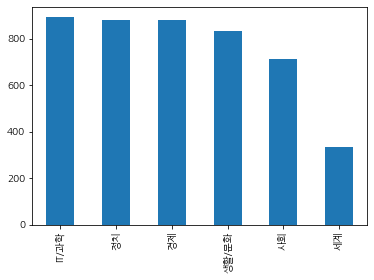

In [45]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [46]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    892
1     경제    879
2     사회    713
3  생활/문화    834
4     세계    333
5     정치    882


## 형태소 분석 및 불용어 제거

In [88]:
from konlpy.tag import Mecab

tokenizer = Mecab()
kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


In [48]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

In [49]:
### 불용어 추가
with open("stopwords.txt", "r") as f:
    lines = f.readlines()
    for l in lines:
        stopwords.append(l)

In [89]:
len(stopwords)

626

In [122]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for i, sentence in enumerate(data):
    try:
        temp_data = []
        #- 토큰화
        temp_data = tokenizer.morphs(sentence) 
    except:
        print("오류 발생", sentence)
        print(i, data[i])
        continue
        
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [99]:
text_data = preprocessing(df['news'])
print(text_data[1])

총회 속보 투표 절차 시작


In [92]:
print(len(text_data))
print(df["code"][327])
print(df["news"][327])

4533
정치
안보리위성발사논의또빈손정부단합대응계속노력


## 머신러닝 활용하여 문장 분류

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn import metrics

In [100]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [101]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 3399
테스트용 뉴스 기사의 개수 :  1134
훈련용 레이블의 개수 :  3399
테스트용 레이블의 개수 :  1134


### TF-IDF 변환

In [131]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = ComplementNB().fit(X_train_tfidf, y_train) # 0.67

In [65]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [118]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['경제']


In [128]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.59      0.80      0.68       198
          경제       0.63      0.52      0.57       228
          사회       0.71      0.60      0.65       191
       생활/문화       0.71      0.63      0.67       216
          세계       0.58      0.71      0.64        76
          정치       0.78      0.81      0.80       225

    accuracy                           0.67      1134
   macro avg       0.67      0.68      0.67      1134
weighted avg       0.68      0.67      0.67      1134



#### 형태소 분석기 >> Okt

In [115]:
from konlpy.tag import Okt

tokenizer = Okt()

In [123]:
text_data = preprocessing(df['news'])
print(text_data[0])

속보 엑스포 후보 개국 최종 종료 투표절차 시작


In [129]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [132]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.59      0.80      0.68       198
          경제       0.63      0.52      0.57       228
          사회       0.71      0.60      0.65       191
       생활/문화       0.71      0.63      0.67       216
          세계       0.58      0.71      0.64        76
          정치       0.78      0.81      0.80       225

    accuracy                           0.67      1134
   macro avg       0.67      0.68      0.67      1134
weighted avg       0.68      0.67      0.67      1134



## 회고

이번 프로젝트를 처음 진행하면서 시간의 소중함을 느꼈습니다.
코드를 잘못 작성했을 때, 그 오랜 기다림 끝에 발생한 에러로 제 하루는 무너졌습니다.
또한 분류할 라벨의 개수가 정확도에 큰 영향을 준다는 점을 다시 한 번 느낄 수 있었습니다.

실제로 라벨도 골고루 분포되어 있는데, 라벨이 3개가 추가된 후로 정확도가 10%정도 낮아졌습니다.
정말 아쉽습니다.

뿐만 아니라, 자연어 처리는 처음 해보는 일이다 보니 더욱 어려웠던 것 같습니다.
정답 코드를 보고 싶습니다.

감사합니다.